# Fossil Dataset Construction
> A notebook demonstrating how to build a dataset using fastai and ipywidgets.
- toc: true
- branch: master
- badges: false
- comments: false
- categories: [projects, jupyter]
- hide: false
- search_exclude: false

# Introduction

I hacked together most of this code in between completing the first few lessons from the fastai course v3. The final product is a site I host internally so that my local paleontologist can label data for me. :)

This was the first big step in one of my projects. The objective of this notebook was to learn about the reddit API and build a dataset I could use to train a model using the `resnet` architecture. It also helped me validate my home setup was complete.

What it didn't teach me is how to integrate with the broader community, which is another reason I wanted to create this blog.

In [17]:
#hide_output
import os
import sys
import re
import glob
from pathlib import Path

import numpy as np
import pandas as pd
import requests

# For generating the widgets
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
from IPython.display import clear_output, display, Image as Img
from IPython.core.display import HTML
import ipyplot

from fastai.vision import *
from fastai.vision import core

# For interacting with reddit
import praw
from praw.models import MoreComments

# For managing our reddit secrets
from dotenv import load_dotenv
load_dotenv()

True

## Data Organization

To get started, we will follow the example in the first lessons by using a dataset that is labeled by the directory name. We will store images in the path below, which we will also use for training with fastai.

In this case, images are saved to the path `/home/tbeck/src/data/fossils`. fastai saves the images using an 8-digit, zero filled identifier. This code does not check for duplicates and does not allow the user to review the existing dataset (e.g. to clean it), although there are some tools now with fastai that might be useful for that purpose.


In [ ]:
dataset_path = Path('/home/tbeck/src/data/fossils')
labels = [x.name for x in dataset_path.iterdir() if (x.is_dir() and x.name not in ['models'])]

## PRAW

We must instantiate the reddit PRAW client, so we do so by passing it environment variables loaded from a `.env` file via the `python-dotenv` package. Using the API, we can obtain URLs to posted images and scrape the reddit comments (useful for getting hints).

In [ ]:
reddit = praw.Reddit(client_id=os.environ['REDDIT_CLIENT_ID'], client_secret=os.environ['REDDIT_SECRET'],
                     password=os.environ['REDDIT_PASSWORD'], user_agent=os.environ['REDDIT_USER_AGENT'],
                     username=os.environ['REDDIT_USERNAME'])

fossilid = reddit.subreddit('fossilid')

We need some helper functions to retrieve the images and save them to our dataset. I found that URLs obtained from reddit need some post processing, otherwise they do not render properly.

In [ ]:
def download_image(url, dest=None):
    """Given a URL, saves the image in a format the fastai likes."""
    dest = Path(dest)
    dest.mkdir(exist_ok=True)
    
    files = glob.glob(os.path.join(dest, '*.jpg')) + glob.glob(os.path.join(dest, '*.png'))
    i = len(files)

    suffix = re.findall(r'\.\w+?(?=(?:\?|$))', url)
    suffix = suffix[0] if len(suffix)>0  else '.jpg'
    
    try: core.download_url(url, dest/f"{i:08d}{suffix}", overwrite=True, show_progress=False)
    except Exception as e: f"Couldn't download {url}."   

def get_image(url, verbose=False):
    """Given a URL, returns the URL if it looks like it's a URL to an image"""
    IMG_TEST = "\.(jpg|png)"
    p = re.compile(IMG_TEST, re.IGNORECASE)
    if p.search(url):
        if verbose:
            print("url to image")
        return url
    
    IMGUR_LINK_TEST = r"((http|https)://imgur.com/[a-z0-9]+)$"
    p = re.compile(IMGUR_LINK_TEST, re.IGNORECASE)
    
    if p.search(url):
        if verbose:
            print("imgur without extension")
        return url + '.jpg'

    IMGUR_REGEX_TEST = r"((http|https)://i.imgur.com/[a-z0-9\.]+?(jpg|png))"
    p = re.compile(IMGUR_REGEX_TEST, re.IGNORECASE)
    
    if p.search(url):
        if verbose:
            print("imgur with extension")
        return url
    
    return None

class Error(Exception):
    def __init__(self, msg):
        self.msg = msg
        
class SubmissionStickiedError(Error):
    pass
class SubmissionIsVideoError(Error):
    pass
class SubmissionNotAnImageError(Error):
    pass
class DisplayError(Error):
    pass

Now we can query reddit for the images. The method below to build the dataset is a little clunky (I create arrays for each column of data and take great steps to be sure they are equal length). A better way would be to delegate creating this data structure to a single function so that the code below is less complex.

In [ ]:
# Fetch submissions for analysis and initialize parallel arrays
submissions = []
images = []
top_comments = []
errors = []
verbose = False

for i, submission in enumerate(reddit.subreddit("fossilid").new(limit=None)):
    submissions.append(submission)
    images.append(None)
    top_comments.append(None)
    errors.append(None)
    
    try:
        if submission.stickied:
            raise SubmissionStickiedError("Post is stickied")
            
        if submission.is_video:
            raise SubmissionIsVideoError("Post is a video")

        if get_image(submission.url):
            if verbose:
                print(f"Title: {submission.title}")
            
            images[i] = get_image(submission.url)

            try:
                if verbose:
                    display(Img(get_image(submission.url), retina=False, height=400, width=400))
            except Exception as err:
                if verbose:
                    print(f"Failed to retrieve transformed image url {get_image(submission.url)} from submission url {submission.url}")
                raise DisplayError(f"Failed to retrieve transformed image url {get_image(submission.url)} from submission url {submission.url}")

            submission.comments.replace_more(limit=None)
            for top_level_comment in submission.comments:
                if verbose:
                    print(f"Comment: \t{top_level_comment.body}")
                top_comments[i] = top_level_comment.body
                break
        else:
            raise SubmissionNotAnImageError("Post is not a recognized image url")
    except Exception as err:
        submissions[i] = None
        images[i] = None
        top_comments[i] = None
        errors[i] = err.msg

df = pd.DataFrame({'submissions': submissions, 'images': images, 'comments': top_comments, 'errors': errors})
df.dropna(how='all', inplace=True)
df.dropna(subset=['images'], inplace=True)

# Widget Requirements

1. Be able quickly jump around in the dataset
2. Render the image
3. Render a hint from the top reddit comment
4. Save the image to disk
5. Skip this image and show the next one
6. Reset the form

In [ ]:
debug = False
output2 = widgets.Output()

reset_button = widgets.Button(description='Reset')

def on_reset_button_click(_):
    with output2:
        clear_output()
        int_range.value = 0
        classes_dropdown.value = None
        new_class.value = ''

reset_button.on_click(on_reset_button_click)

save_button = widgets.Button(
    description='Save',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Save',
    icon='check'
)

skip_button = widgets.Button(
    description='Skip',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Skip',
    icon=''
)

int_range = widgets.IntSlider(
    value=0,
    min=0,
    max=len(df) - 1,
    step=1,
    description='Submission:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)

img = widgets.Image(
    value=requests.get(df.iloc[int_range.value]['images']).content,
    format='png',
    width=480,
    height=640,
)

reddit_link = widgets.Label('Link: ' + str(df.iloc[int_range.value]['submissions'].url))
comment = widgets.Label('Hint: ' + str(df.iloc[int_range.value]['comments']))

local_options = [x.name for x in dataset_path.iterdir() if (x.is_dir() and x.name not in ['models'])]
local_options.sort()

classes_dropdown = widgets.Dropdown(
    options=[None] + local_options,
    value=None,
    description='Class:',
    disabled=False,
)

# Free form text widget
new_class = widgets.Text(
    value=None,
    placeholder='',
    description='New Class:',
    disabled=False
)

def on_save_button_click(_):
    err=None
    if len(new_class.value) > 0:
        label = new_class.value
    elif classes_dropdown.value:
        label = classes_dropdown.value
    else:
        err = "You must specify a label to save to."
    
    with output2:
        clear_output()
        if err:
            print(err)
        else:
            if debug:
                print(f"Would fetch index {int_range.value} from {df.iloc[int_range.value]['images']} to {dataset_path/label}")
            else:
                Path(Path(dataset_path)/Path(label)).mkdir(exist_ok=True)
                core.download_url(f"{df.iloc[int_range.value]['images']}", f"{dataset_path/label}", show_progress=False, timeout=10)
                local_options = [x.name for x in dataset_path.iterdir() if (x.is_dir() and x.name not in ['models'])]
                local_options.sort()
                classes_dropdown.options = [None] + local_options
                
            int_range.value = int_range.value + 1
            classes_dropdown.value = None
            new_class.value = ''

def on_skip_button_click(_):
    with output2:
        clear_output()
        int_range.value = int_range.value + 1
        classes_dropdown.value = None
        new_class.value = ''

save_button.on_click(on_save_button_click)
skip_button.on_click(on_skip_button_click)

def on_value_change(change):
    img.value = requests.get(df.iloc[change['new']]['images']).content
    reddit_link.value = 'Link: ' + str(df.iloc[int_range.value]['submissions'].url)
    comment.value='Hint: ' + str(df.iloc[change['new']]['comments'])
    #with output2:
    #    print(change['new'])

int_range.observe(on_value_change, names='value')

buttons = widgets.HBox([save_button, skip_button, reset_button])
entry = widgets.HBox([classes_dropdown, new_class])
things = widgets.VBox([int_range, img, reddit_link, comment, entry, buttons, output2])

display(things)

# Widgets

To build the dataset and gain context, I created a custom widget for my local paleontologist to use. Here, she can easily navigate the images and apply labels. This widget was a composite of multiple ipywidgets to appear as a single form:

* A slider so they can quickly jump between submissions
* Drop down and text fields that can be populated with fixed or freeform data
* Buttons for saving data, advancing, and resetting the form.

In addition, I show the reddit comment using a label as a hint to the user.

When the widget is rendered, it uses the DataFrame to retrieve the image from the url.

The 'Class' dropdown is created from the labels loaded above. When 'New Class' is not empty and 'Save' is pressed, a new directory is created (if needed) and the image is saved there using fastai (see `download_image()`).

Here is what the widget ends up looking like:

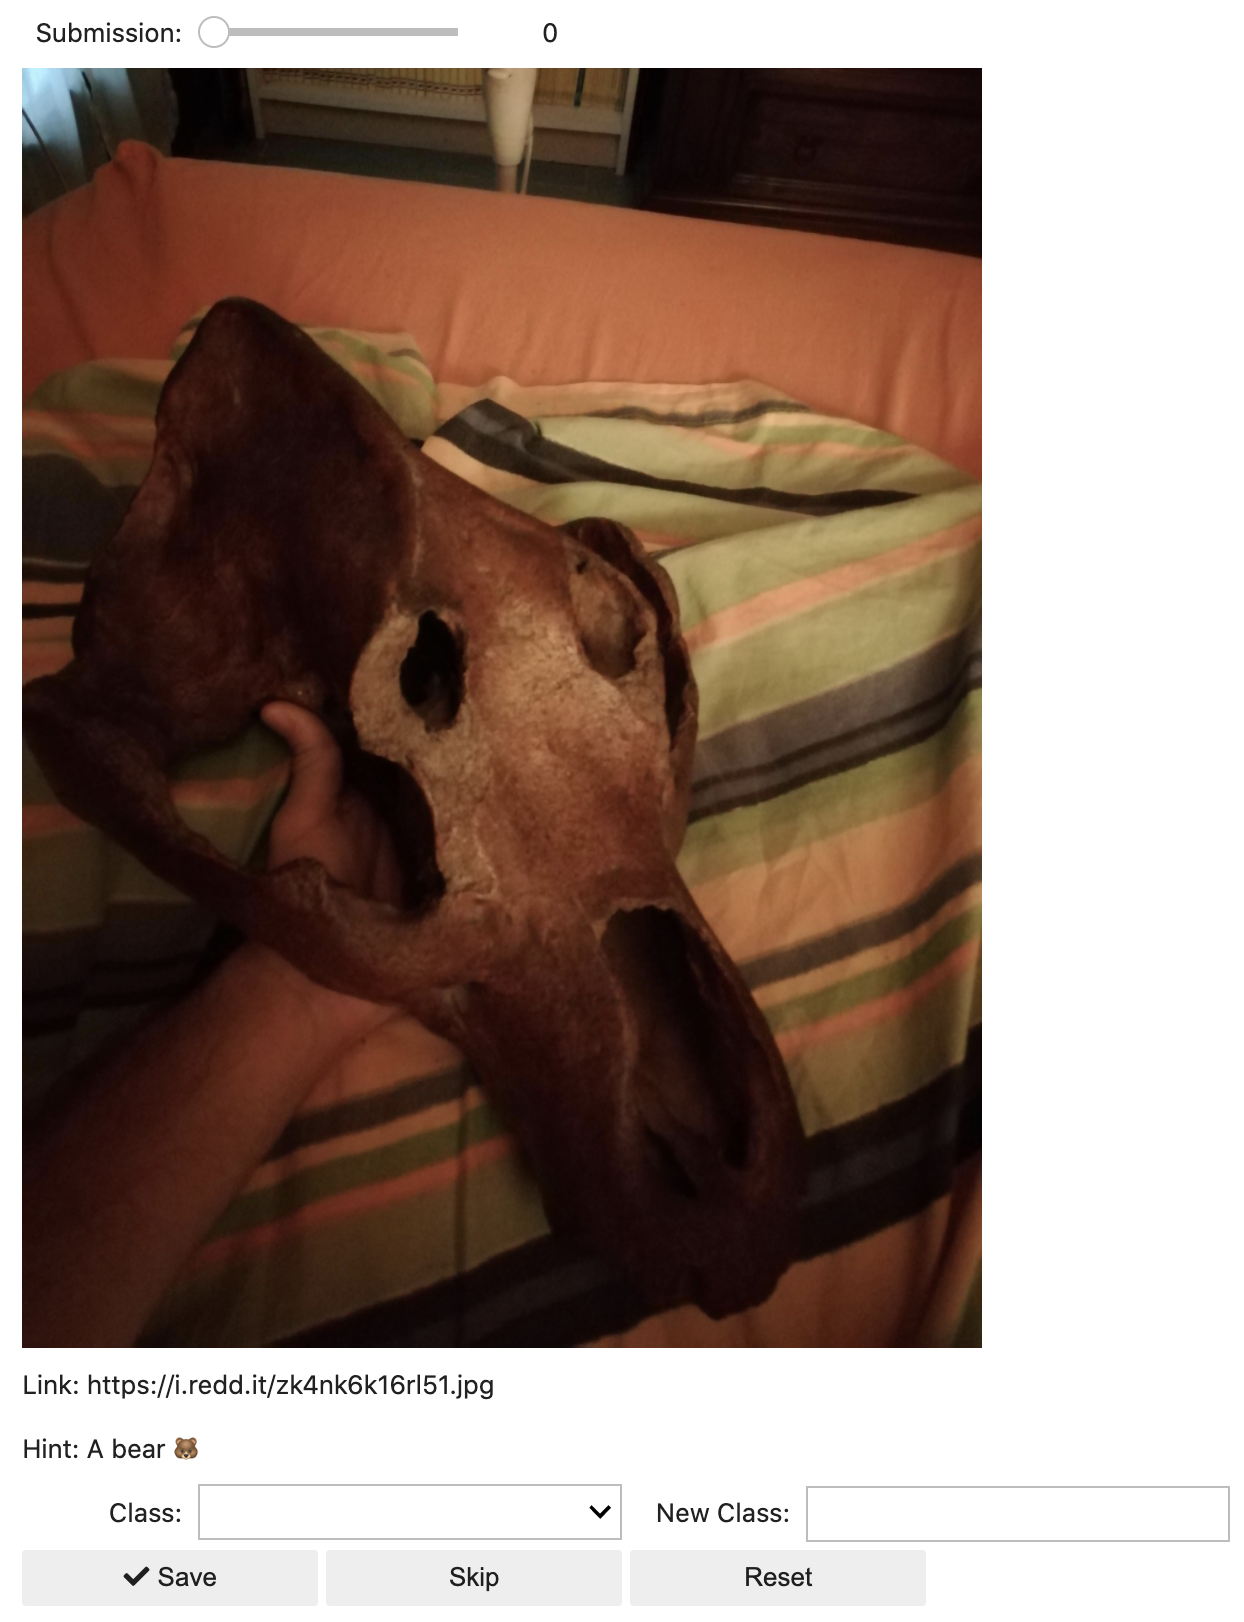

In [18]:
#hide_input
Img('fossil_widget.png',width=640)

## Reviewing The Dataset
Because the data is stored in a DataFrame, we can easily manipulate the information we've scraped. The `ipyplot` package is useful for generating thumbnails from a series of urls. This makes it easy to quickly review what's been scraped.

In [ ]:
ipyplot.plot_images(df['images'], max_images=80, img_width=100)

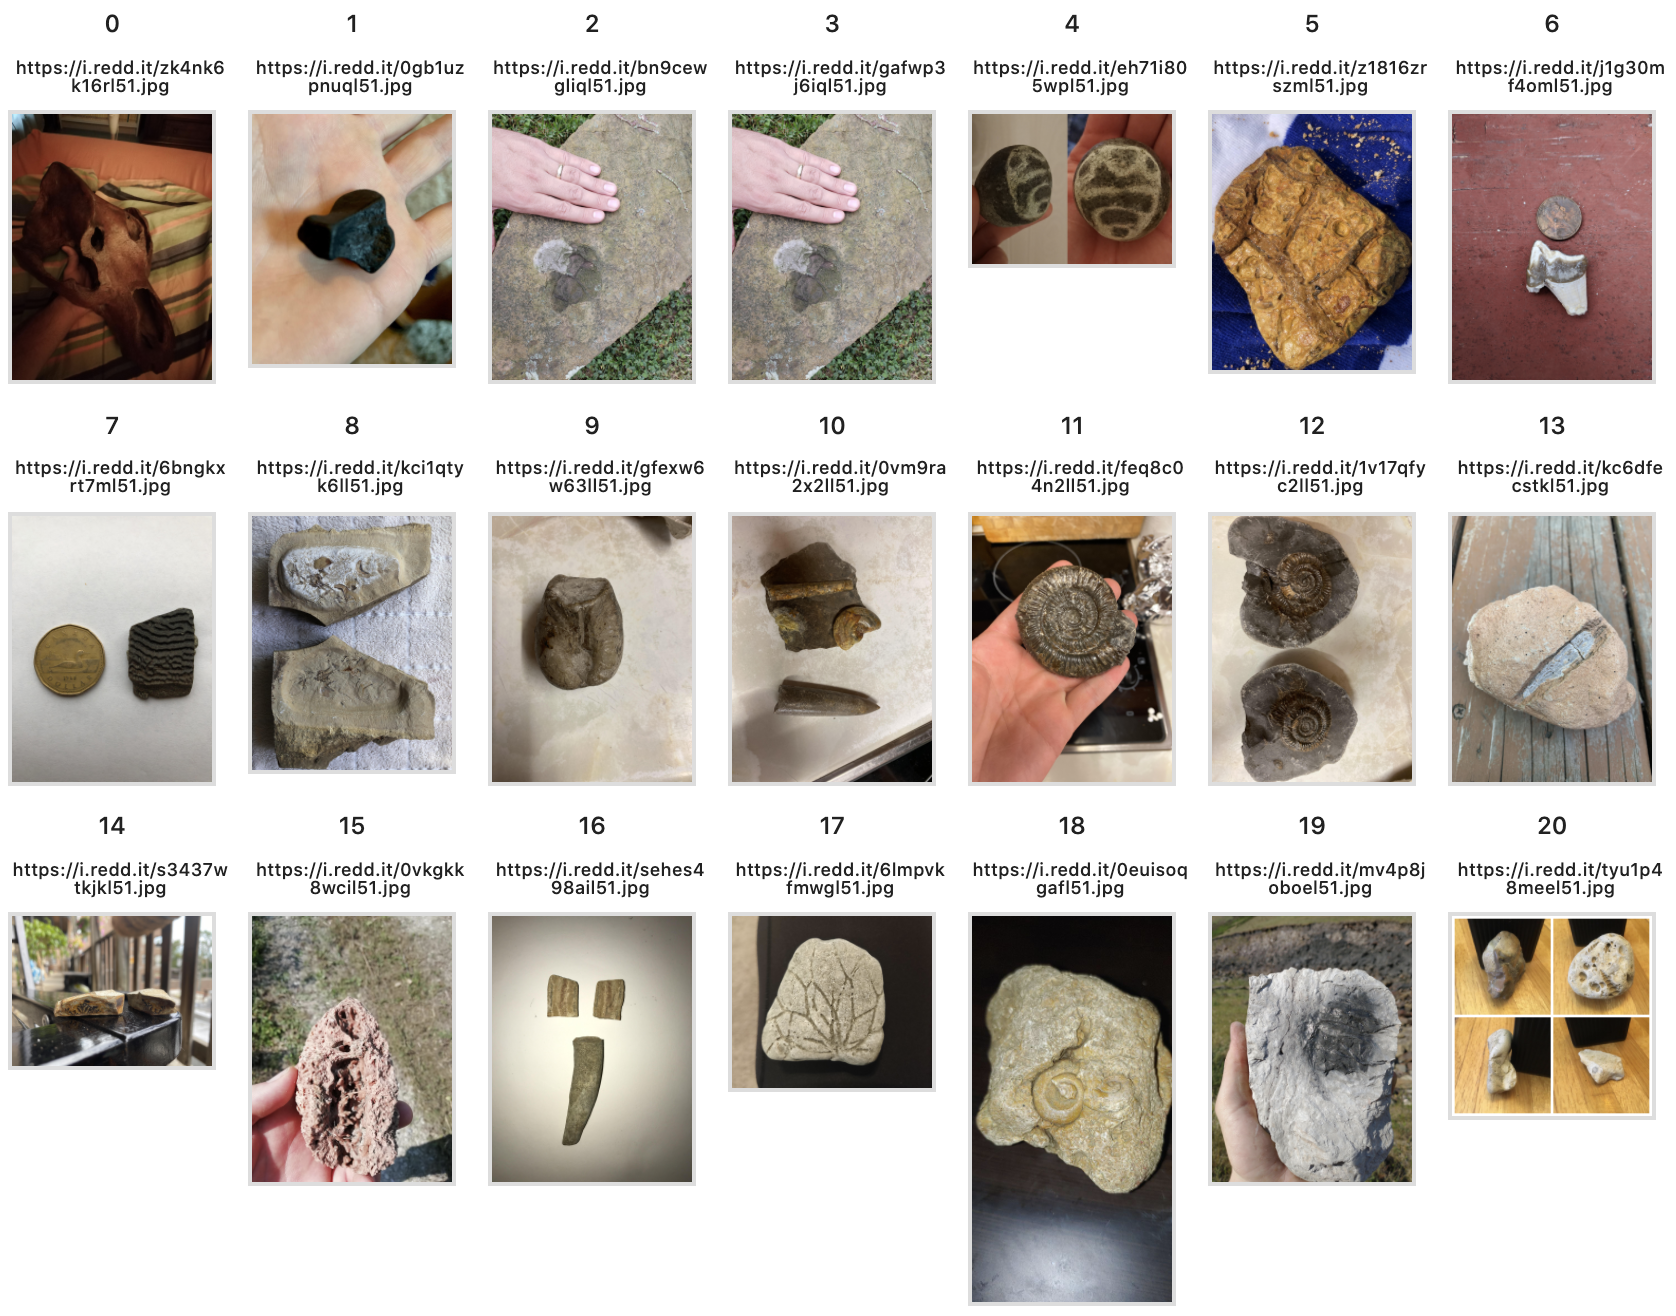

In [16]:
#hide_input
Img('fossil_matrix.png')

# Lessons Learned

Functionality here is somewhat similar to what other widgets can do, such as [superintendent](https://github.com/janfreyberg/superintendent). But this was a good exercise to dust off my ipywidget skills, experiment with interacting with reddit's API, and building a custom dataset using fastai.

I built this notebook when fastai's course v3 was still out, when Google images was being scraped rather than the Bing search API being used.